## Plant disease classification with PyTorch

In [23]:
import torch
import glob
import os
import cv2
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
import numpy as np
from collections import defaultdict

### Download and extract data

In [24]:
# Uncomment to download data - 1.3GB 
# !curl -L -o ~/Downloads/plant-disease-recognition-dataset.zip\
#   https://www.kaggle.com/api/v1/datasets/download/rashikrahmanpritom/plant-disease-recognition-dataset
# !unzip ~/Downloads/plant-disease-recognition-dataset.zip -d ./data

In [25]:
train_path = "./data/Train/"
test_path = "./data/Test/"
validation_path = "./data/Validation/"
train_images = glob.glob(train_path+"**/*.jpg", recursive=True)
test_images = glob.glob(test_path+"**/*.jpg", recursive=True)
validation_images = glob.glob(validation_path+"**/*.jpg", recursive=True)

In [26]:
train_images[-2:]
#len(train_images)

['./data/Train/Rust/dfcc6b28063a88fc.jpg',
 './data/Train/Rust/aacedff0d881c189.jpg']

In [27]:
class PlantsLeavesDataset(Dataset):
    """Plants leaves dataset."""

    def __init__(self, image_paths, transform=None):
        """
        """
        self.label_map = {'Healthy': 0, 'Powdery':1, 'Rust':2}
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_paths[idx]
        image = cv2.imread(img_name)
        label_name = img_name.split('/')[-2]
        label = self.label_map[label_name]
        # label = np.array([label], dtype=float)

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(35),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
])

In [29]:
train_set = PlantsLeavesDataset(train_images, train_transform)
test_set = PlantsLeavesDataset(test_images, test_transform)
validation_set = PlantsLeavesDataset(validation_images, test_transform)

In [30]:
# shapes = defaultdict(int)
# for i in range(len(train_set)):
#     s = tuple(train_set[i][0].shape)
#     shapes[s] += 1
# shapes

In [31]:
batch_size = 64
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(validation_set, shuffle=False, batch_size=batch_size, drop_last=True)

In [32]:
next(iter(train_loader))

[tensor([[[[0.4557, 0.4590, 0.4545,  ..., 0.3699, 0.3746, 0.3764],
           [0.4559, 0.4608, 0.4525,  ..., 0.3724, 0.3750, 0.3792],
           [0.4603, 0.4651, 0.4533,  ..., 0.3680, 0.3762, 0.3740],
           ...,
           [0.4874, 0.4841, 0.4797,  ..., 0.6202, 0.6229, 0.6118],
           [0.4905, 0.4840, 0.4791,  ..., 0.6148, 0.6187, 0.6044],
           [0.4887, 0.4860, 0.4803,  ..., 0.6078, 0.6141, 0.5984]],
 
          [[0.5577, 0.5633, 0.5733,  ..., 0.4746, 0.4734, 0.4745],
           [0.5579, 0.5651, 0.5712,  ..., 0.4771, 0.4739, 0.4773],
           [0.5622, 0.5694, 0.5717,  ..., 0.4723, 0.4747, 0.4716],
           ...,
           [0.5936, 0.5911, 0.5920,  ..., 0.6708, 0.6610, 0.6481],
           [0.5964, 0.5906, 0.5917,  ..., 0.6724, 0.6616, 0.6458],
           [0.5946, 0.5927, 0.5929,  ..., 0.6753, 0.6636, 0.6461]],
 
          [[0.3459, 0.3509, 0.3579,  ..., 0.2550, 0.2538, 0.2549],
           [0.3461, 0.3527, 0.3559,  ..., 0.2575, 0.2543, 0.2577],
           [0.3504, 0.35

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026038919..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08110389..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.025259443..1.0000001].


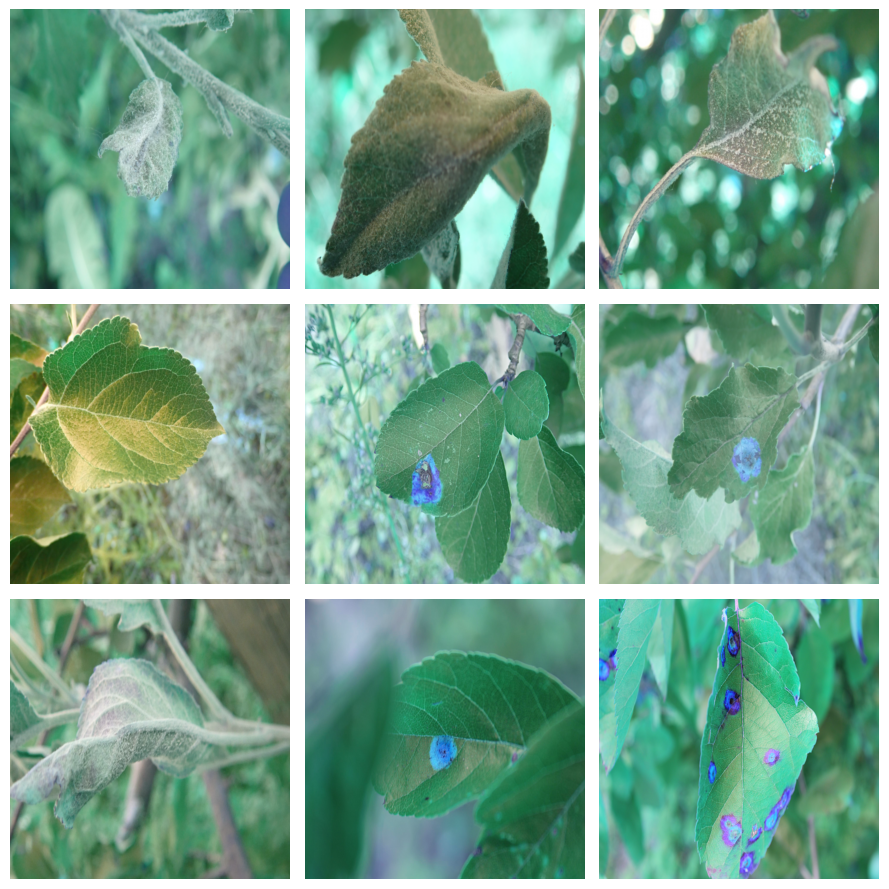

In [33]:
ims, labels = next(iter(train_loader))
ims = torch.einsum("bchw->bhwc", ims)
rows, cols = 3, 3
ims = ims[:rows*cols].view(rows, cols, 512, 512, 3)
fig, axs = plt.subplots(rows, cols, figsize=(3*rows, 3*cols))
for A, I in zip(axs,ims):
    for ax, img in zip(A,I):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.imshow(img)
fig.tight_layout()
#fig.subplots_adjust(hspace=0, wspace=0)
#plt.savefig(save_fig_path, facecolor='w', edgecolor='none')
plt.show()


### Define RESNET model

In [34]:
"""
conv1: 512 -> 256 : 8
conv2: 256 -> 128 : 16
res
conv3: 128 -> 64 : 32
conv4: 64 -> 32 : 64
res
conv5: 32 -> 16 : 128
conv6: 16 -> 8 : 256
res
conv7: 8 -> 4 : 512
conv8: 4 -> 2 : 1024
res
flatten: 1024 x 2 x 2
linear1: 512
linear2: 128
linear3: 32
linear4: 3
"""

# Conv block used in Resnet model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Linear layer block
def linear_block(in_features, out_features, activation=True, batchnorm=False, flatten=False):
    layers = []
    if flatten:
        layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features, out_features))
    if batchnorm:
        layers.append(nn.BatchNorm1d(out_features))
    if activation:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Resnet9
class RESNET20(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(RESNET20, self).__init__()
        self.conv1 = conv_block(in_channels, 8, pool=True)
        self.conv2 = conv_block(8, 16, pool=True)
        self.res1 = nn.Sequential(conv_block(16, 16), conv_block(16, 16))

        self.conv3 = conv_block(16, 32, pool=True)
        self.conv4 = conv_block(32, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.conv5 = conv_block(64, 128, pool=True)
        self.conv6 = conv_block(128, 256, pool=True)
        self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv7 = conv_block(256, 512, pool=True)
        self.conv8 = conv_block(512, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        # dense layers
        self.fc1 = linear_block(1024*2*2, 512, flatten=True)
        self.fc2 = linear_block(512, 128)
        self.fc3 = linear_block(128, 32)
        self.fc4 = linear_block(32, num_classes, activation=False)

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.res1(x) + x
        x = self.conv4(self.conv3(x))
        x = self.res2(x) + x
        x = self.conv6(self.conv5(x))
        x = self.res3(x) + x
        x = self.conv8(self.conv7(x))
        x = self.res4(x) + x
        x = self.fc2(self.fc1(x))
        return self.fc4(self.fc3(x))

    def model_summary(self):
        return summary(self, input_size=(3,512,512))


In [35]:
# test the model and output shape
test_input = torch.randn((64,3,512,512))
test_model = RESNET20(3,3)
test_out = test_model(test_input)
test_out.shape

torch.Size([64, 3])

torch.Size([64, 1024, 2, 2])